In [ ]:
import pandas as pd
import numpy as np

# Step 1: Load the dataset
df_raw = pd.read_csv('patient_adherence_dataset.csv')

DATA CLEANING

In [ ]:
# Step 2: Define encoding maps as per your schema
encoding_maps = {
    'Gender': {'Male': 0, 'Female': 1},
    'Education_Level': {'None': 0, 'High School': 1, 'College': 2, 'Graduate': 3},
    'Social_Support_Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Condition_Severity': {'Mild': 0, 'Moderate': 1, 'Severe': 2},
    'Healthcare_Access': {'Poor': 0, 'Moderate': 1, 'Good': 2},
    'Mental_Health_Status': {'Poor': 0, 'Fair': 1, 'Good': 2}
}

# Step 3: Apply encoding
df_clean = df_raw.copy()

for col, mapping in encoding_maps.items():
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map(mapping)

# Step 4: One-hot encode Medication_Type
if 'Medication_Type' in df_clean.columns:
    df_clean = pd.get_dummies(df_clean, columns=['Medication_Type'])

# Step 5: Check and handle missing values
missing_values = df_clean.isnull().sum()
print("Missing values per column before handling:")
print(missing_values)

for col in df_clean.columns:
    if df_clean[col].isnull().any():
        if df_clean[col].dtype in [np.float64, np.int64]:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
        else:
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)

# Step 6: Final check and preview
print("\nMissing values after handling:")
print(df_clean.isnull().sum())

print("\nCleaned data sample:")
print(df_clean.head())

Missing values per column before handling:
Age                         0
Gender                     73
Dosage_mg                   0
Previous_Adherence          0
Education_Level           987
Income                      0
Social_Support_Level        0
Condition_Severity          0
Comorbidities_Count         0
Healthcare_Access        2033
Mental_Health_Status     1479
Insurance_Coverage          0
Adherence                   0
Medication_Type_TypeA       0
Medication_Type_TypeB       0
Medication_Type_TypeC       0
dtype: int64

Missing values after handling:
Age                      0
Gender                   0
Dosage_mg                0
Previous_Adherence       0
Education_Level          0
Income                   0
Social_Support_Level     0
Condition_Severity       0
Comorbidities_Count      0
Healthcare_Access        0
Mental_Health_Status     0
Insurance_Coverage       0
Adherence                0
Medication_Type_TypeA    0
Medication_Type_TypeB    0
Medication_Type_TypeC    0


/tmp/ipython-input-2-2814199322.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)


EDA - VISUALISING FEATURES AND RELATIONSHIPS

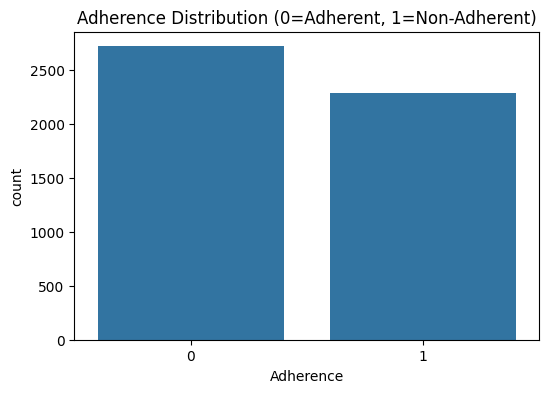

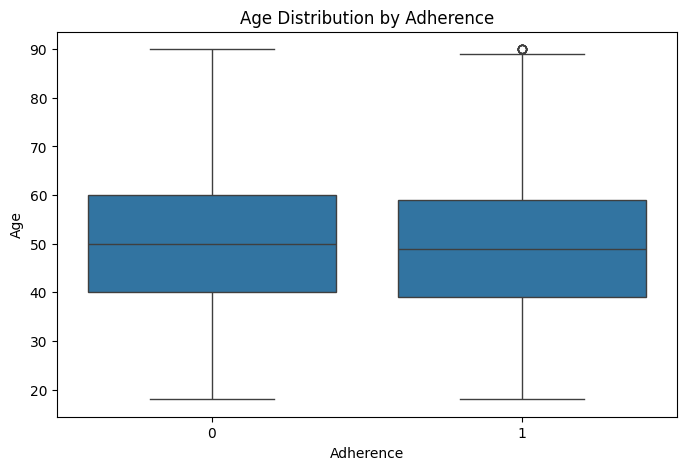

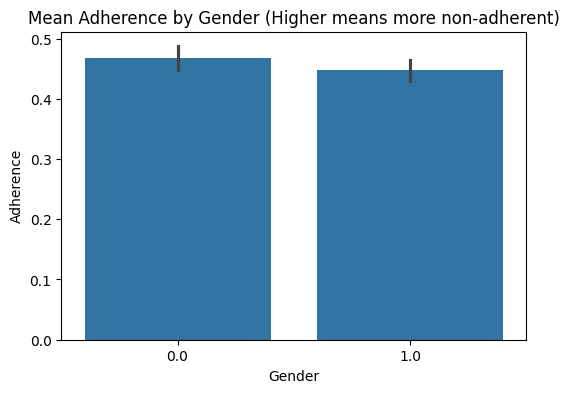

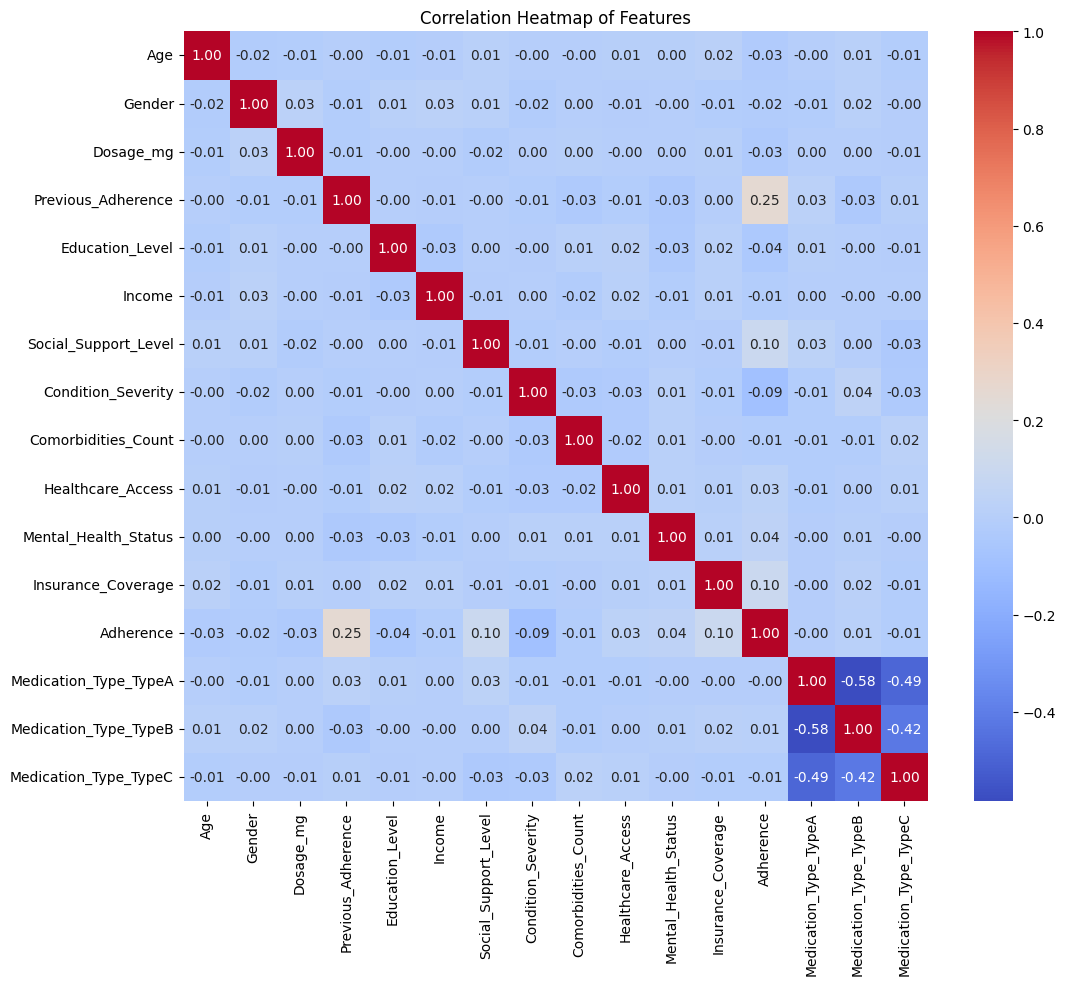

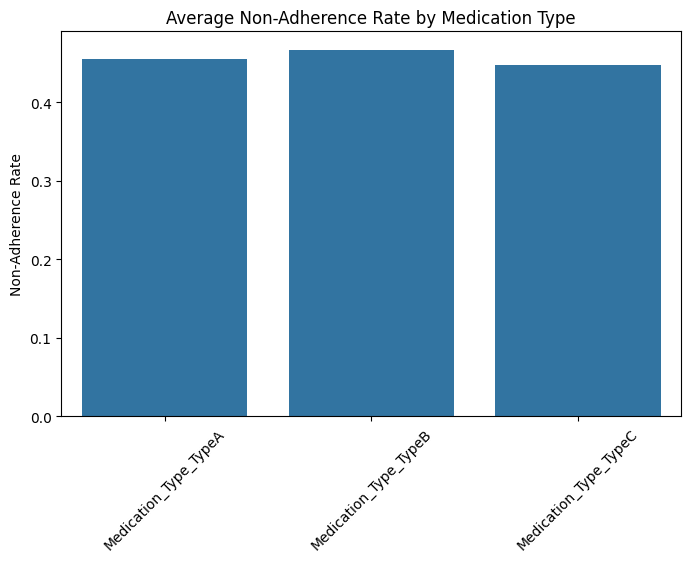

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the cleaned dataframe 'df_clean' from previous step

# 1. Adherence Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Adherence', data=df_clean)
plt.title('Adherence Distribution (0=Adherent, 1=Non-Adherent)')
plt.show()

# 2. Age Distribution by Adherence
plt.figure(figsize=(8,5))
sns.boxplot(x='Adherence', y='Age', data=df_clean)
plt.title('Age Distribution by Adherence')
plt.show()

# 3. Adherence by Gender
plt.figure(figsize=(6,4))
sns.barplot(x='Gender', y='Adherence', data=df_clean)
plt.title('Mean Adherence by Gender (Higher means more non-adherent)')
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(12,10))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# 5. Medication Type vs Adherence
# Extract medication columns (one-hot encoded start with 'Medication_Type_')
med_cols = [col for col in df_clean.columns if col.startswith('Medication_Type_')]

med_adherence = {}
for med in med_cols:
    med_adherence[med] = df_clean.loc[df_clean[med] == 1, 'Adherence'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=list(med_adherence.keys()), y=list(med_adherence.values()))
plt.title('Average Non-Adherence Rate by Medication Type')
plt.ylabel('Non-Adherence Rate')
plt.xticks(rotation=45)
plt.show()


ML MODELS

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:24:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Logistic Regression ---
Accuracy: 0.6210
Precision: 0.6097
Recall: 0.5570
F1 Score: 0.5821
ROC AUC: 0.6713
Confusion Matrix:
[[357 169]
 [210 264]]

--- Random Forest ---
Accuracy: 0.5940
Precision: 0.5842
Recall: 0.4979
F1 Score: 0.5376
ROC AUC: 0.6302
Confusion Matrix:
[[358 168]
 [238 236]]

--- XGBoost ---
Accuracy: 0.5890
Precision: 0.5734
Recall: 0.5190
F1 Score: 0.5449
ROC AUC: 0.6134
Confusion Matrix:
[[343 183]
 [228 246]]



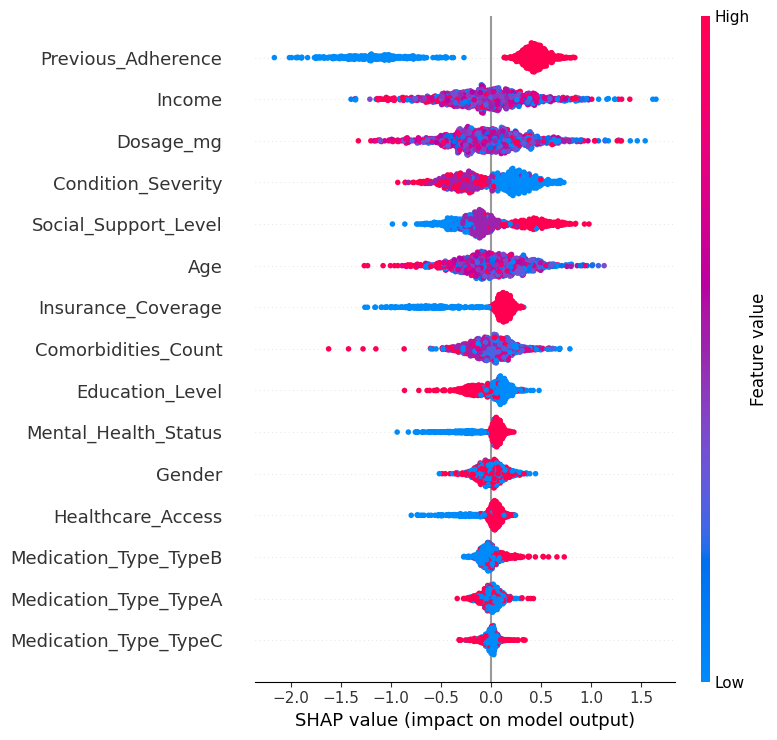

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap

# 1. Prepare data
X = df_clean.drop(columns=['Adherence'])
y = df_clean['Adherence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Train, predict, evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# 4. Display results
for model_name, metrics in results.items():
    print(f"--- {model_name} ---")
    for metric_name, metric_val in metrics.items():
        if metric_name != 'Confusion Matrix':
            print(f"{metric_name}: {metric_val:.4f}")
        else:
            print(f"{metric_name}:\n{metric_val}")
    print()

# 5. Feature importance for best model (say XGBoost)
best_model = models['XGBoost']
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


DATASET FEATURE ENGINEERING

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Prepare data
X = df_clean.drop(columns=['Adherence'])
y = df_clean['Adherence']

# 2. Train-test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Define pipelines with SMOTE + classifier
pipelines = {
    'Logistic Regression': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
}

# 4. Hyperparameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [5, 10, None],
        'clf__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'clf__learning_rate': [0.01, 0.1],
        'clf__max_depth': [3, 5],
        'clf__n_estimators': [100, 200],
        'clf__subsample': [0.8, 1]
    }
}

# 5. Train, tune and evaluate models
results = {}
best_auc = 0
best_model_name = None
best_model = None

for model_name in pipelines:
    print(f"\nTraining and tuning {model_name}...")
    grid_search = GridSearchCV(
        estimator=pipelines[model_name],
        param_grid=param_grids[model_name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print(f"Best params for {model_name}: {grid_search.best_params_}")

    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]

    acc = grid_search.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_prob)
    clf_report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n", clf_report)
    print("Confusion Matrix:\n", cm)

    results[model_name] = {
        'model': grid_search.best_estimator_,
        'accuracy': acc,
        'roc_auc': roc_auc,
        'classification_report': clf_report,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    # Track best model by ROC AUC
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model_name = model_name
        best_model = grid_search.best_estimator_

print(f"\nBest model: {best_model_name} with ROC AUC = {best_auc:.4f}")

# 6. Export predictions from best model for Power BI
output_df = X_test.copy()
output_df['Actual_Adherence'] = y_test
output_df['Predicted_Adherence'] = results[best_model_name]['y_pred']
output_df['Predicted_Probability'] = results[best_model_name]['y_prob']

output_df.to_csv('adherence_predictions_for_powerbi.csv', index=False)

print("Predictions saved to 'adherence_predictions_for_powerbi.csv'")



Training and tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for Logistic Regression: {'clf__C': 1, 'clf__solver': 'liblinear'}
Accuracy: 0.6946
ROC AUC: 0.6946
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.58      0.63       543
           1       0.59      0.71      0.64       457

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.64      1000
weighted avg       0.65      0.64      0.64      1000

Confusion Matrix:
 [[314 229]
 [134 323]]

Training and tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for Random Forest: {'clf__max_depth': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Accuracy: 0.6954
ROC AUC: 0.6954
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.65       543
           1      

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Accuracy: 0.6936
ROC AUC: 0.6936
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.60      0.64       543
           1       0.59      0.68      0.63       457

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.63      1000
weighted avg       0.64      0.64      0.64      1000

Confusion Matrix:
 [[325 218]
 [147 310]]

Best model: Random Forest with ROC AUC = 0.6954
Predictions saved to 'adherence_predictions_for_powerbi.csv'
